In [472]:
import ase
import os
import numpy as np
import pandas as pd
import pickle
import sys
from joblib import load, dump
from tqdm.autonotebook import tqdm
from pymatgen.core.structure import Structure
from ase.io import read, write
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import NeighborList
from pymatgen.core.structure import Structure
from pymatgen.analysis.local_env import CrystalNN
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as mp
mp.rcParams['agg.path.chunksize'] = 10000

from structure_search.embedding.Calculate_SOAP import CalculateSOAP
from structure_search.embedding.Calculate_ChemEnv import CalculateChemEnv
from structure_search.strategy.ANNOY import AnnoySearch
from structure_search.utils.VisualizeMatches import *
from ast import literal_eval
from sklearn.metrics import mean_absolute_error 
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from tqdm import tqdm

In [380]:
import numpy 
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')


## Read input

In [3]:
traj=read('../sabrina_data/eval_training_dataset.xyz', index=':')

In [4]:
traj

[Atoms(symbols='Li11Ni12O24', pbc=True, cell=[[-5.746783718, -0.01920085, -0.0001356], [2.857274182, 1.691495686, 4.623709412], [0.067868263, 12.967303959, -5.058979061]], MACE_forces=..., forces=..., magmoms=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='Li7Ni12O24', pbc=True, cell=[[2.782634485, -4.80641245, 0.002962443], [4.310383632, 5.690183824, -4.863428735], [1.498309266, 0.857751737, 9.373680946]], MACE_forces=..., forces=..., magmoms=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='Li4Ni14O28', pbc=True, cell=[[-4.228587029, 2.441375838, -0.094787552], [1.422578364, -0.821329303, 4.774241974], [9.659895547, 16.73142806, -1.1513e-05]], MACE_forces=..., forces=..., magmoms=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='Li7Ni12O24', pbc=True, cell=[[-2.757276202, -3.619813677, 4.360897216], [-5.593952919, 3.709348772, -4.405376312], [2.807050624, -6.21202659, -5.340560371]], MACE_forces=..., forces=..., magmoms=..., calculator=SinglePointCa

In [473]:
for i,atoms in tqdm(enumerate(traj)):
    write("../sabrina_data/data/"+str(i)+".xyz", atoms)

37743it [04:11, 150.37it/s]


In [299]:
len(traj)

37743

In [89]:
traj[0].get_total_energy()

-438.86147638

## Test Energy

In [219]:
traj[0].todict()['info']

{'energy': -438.86147638,
 'stress': array([[-2.09777122e-05,  1.60344369e-05, -1.00088840e-04],
        [ 1.60344369e-05,  1.07815829e-04, -3.02575879e-04],
        [-1.00088840e-04, -3.02575879e-04,  5.33649030e-06]]),
 'magmom': 11.0,
 'free_energy': -438.86152932,
 'MACE_energy': -438.880188500549}

In [220]:
energy=[]
for atoms in traj:
    dft=atoms.todict()['info']['energy']
    mace=atoms.todict()['info']['MACE_energy']
    energy.append((dft,mace))

In [221]:
ene_df=pd.DataFrame(energy, columns=['dft', 'mace'])

<Axes: xlabel='dft', ylabel='mace'>

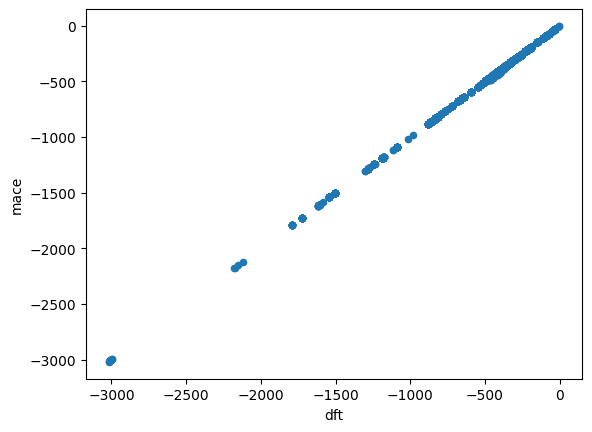

In [223]:
ene_df.plot(x='dft', y='mace', kind='scatter')

In [226]:
mae = mean_absolute_error(ene_df['dft'], ene_df['mace'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.06204858101751192


## Test Magmoms

In [411]:
sum(abs(number) for number in traj[34].get_array('magmoms')), sum((number) for number in traj[34].get_array('magmoms')), 

(3.8859999999999983, 2.9460000000000015)

In [412]:
traj[34].todict()['info']['magmom']

3.0000007

In [450]:
energy=[]
for atoms in traj:
    dft=atoms.todict()['info']['energy']
    mace=atoms.todict()['info']['MACE_energy']
    try:
        magmom=atoms.todict()['info']['magmom']
    except:
        magmom=100
    energy.append((dft,mace,magmom))

ene_df=pd.DataFrame(energy, columns=['dfte', 'macee','magmom'])

array([[<Axes: title={'center': 'magmom'}>]], dtype=object)

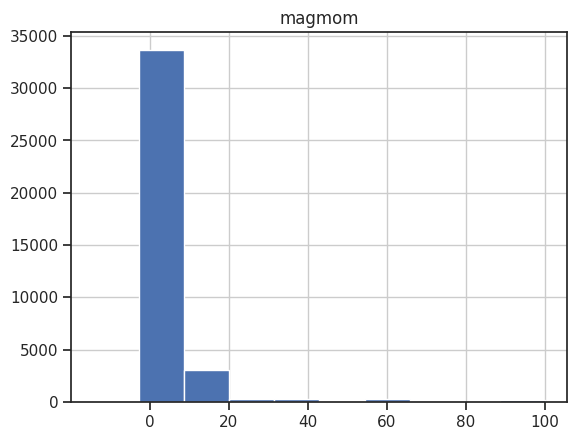

In [451]:
ene_df.hist('magmom')

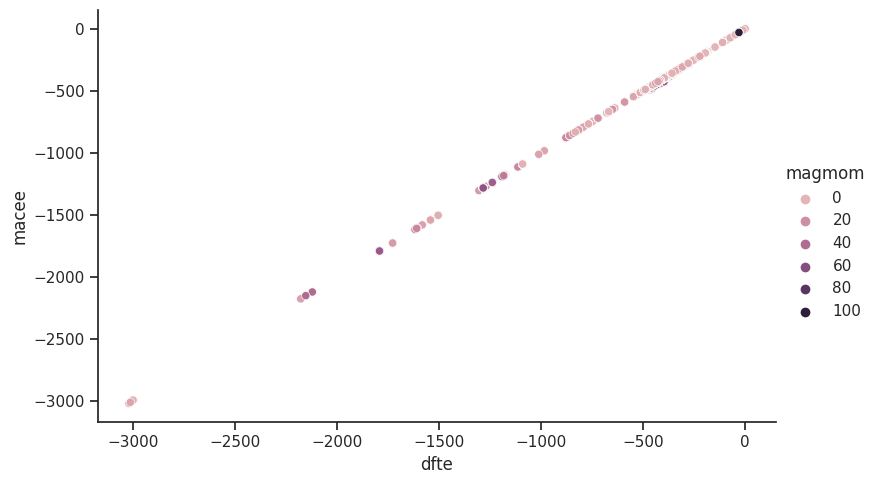

In [453]:
sns.relplot(data=ene_df, x='dfte', y='macee', hue='magmom',aspect=1.61)
plt.show()

## Test Forces

#### Norm

In [148]:
force2=[]
for atoms in traj:
    dft=np.linalg.norm(atoms.arrays['forces'])
    mace=np.linalg.norm(atoms.arrays['MACE_forces'])
    force2.append((dft,mace))

In [149]:
f2df=pd.DataFrame(force2, columns=['dft', 'mace'])

<Axes: xlabel='dft', ylabel='mace'>

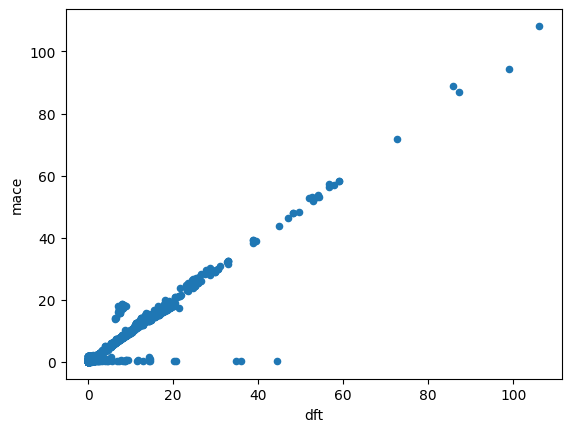

In [150]:
f2df.plot(x='dft', y='mace', kind='scatter')

In [433]:
[8]*4

[8, 8, 8, 8]

### Sum

In [444]:
forces=[]
for i,t in enumerate(traj):
    dftf=np.sum(t.arrays['forces'], axis=1)
    macef=np.sum(t.arrays['MACE_forces'], axis=1)
    try:
        magmom=t.arrays['magmoms']
    except:
        magmom=[10]*len(dftf)
    for l in range(len(dftf)):
        forces.append((i,l, dftf[l],macef[l], t.get_chemical_symbols()[l], len(dftf), magmom[l]))

In [445]:
fdf=pd.DataFrame(forces, columns=['frame','atom_idx', 'dft', 'mace', 'element', 'no_atoms', 'magmom'])

In [446]:
fdf

,frame,atom_idx,dft,mace,element,no_atoms,magmom
0,0,0,-0.001696,-0.042027,Li,47,0.003
1,0,1,-0.000766,-0.074013,Li,47,0.010
2,0,2,-0.003454,-0.105438,Li,47,0.010
3,0,3,-0.000510,-0.079769,Li,47,0.012
4,0,4,-0.001658,-0.005400,Li,47,0.011
...,...,...,...,...,...,...,...
1630655,37742,19,0.009548,-0.031147,O,24,0.056
1630656,37742,20,0.004859,-0.102516,O,24,0.058
1630657,37742,21,0.011142,0.081655,O,24,0.043
1630658,37742,22,0.014228,0.055438,O,24,0.056


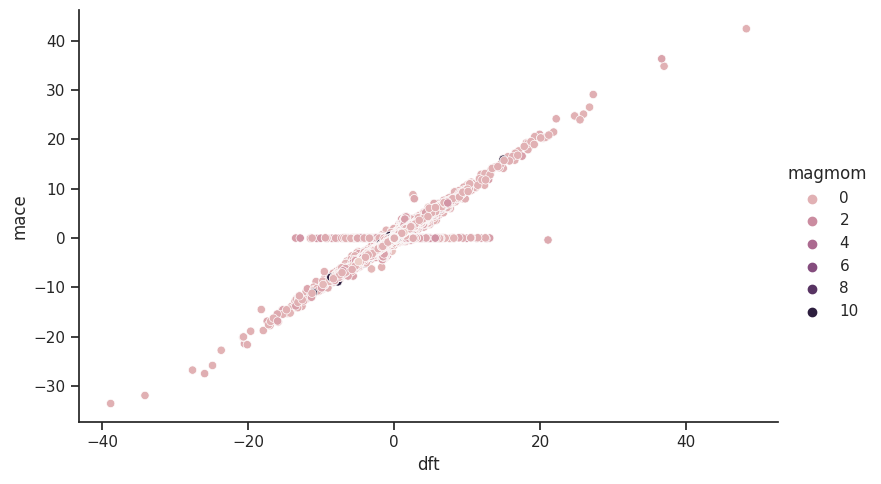

In [447]:
sns.relplot(data=fdf, x='dft', y='mace',hue='magmom', aspect=1.61)
plt.show()

## Extract problematic datapoints

In [302]:
from sklearn.metrics import mean_absolute_error 
import numpy as np

mae = mean_absolute_error(fdf['dft'], fdf['mace'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.04795752330221507


In [303]:
fdf['diff']=abs(fdf['dft']-fdf['mace'])

In [412]:
fdf[fdf['diff']>0.1]

,frame,atom_idx,dft,mace,element,no_atoms,diff
2,0,2,-0.003454,-0.105438,Li,47,0.101984
5,0,5,0.000703,0.105982,Li,47,0.105279
19,0,19,0.012665,-0.087618,Ni,47,0.100283
74,1,27,-0.096369,0.006686,O,43,0.103055
84,1,37,-0.089037,0.016774,O,43,0.105811
...,...,...,...,...,...,...,...
1630644,37742,8,-0.004529,-0.132880,Ni,24,0.128351
1630645,37742,9,-0.001275,0.111424,Ni,24,0.112699
1630650,37742,14,-0.016501,-0.152344,O,24,0.135843
1630651,37742,15,-0.004477,0.128440,O,24,0.132917


In [430]:
error_df=fdf[fdf['diff']>1]

In [431]:
error_df

,frame,atom_idx,dft,mace,element,no_atoms,diff,TSNE_0,TSNE_1
4814,105,34,3.126624,4.301485,Ni,312,1.174861,46.022802,-41.923996
4844,105,64,-4.079446,-2.609252,Ni,312,1.470194,44.264795,-43.358377
4919,105,139,-13.371767,-12.305210,O,312,1.066557,-49.526758,-1.768618
4935,105,155,-7.930924,-6.742278,O,312,1.188646,0.859240,-51.001010
4941,105,161,0.875404,2.111908,O,312,1.236504,1.931036,-46.931815
...,...,...,...,...,...,...,...,...,...
1605306,37153,46,1.453689,3.857184,O,48,2.403495,-116.952850,-48.991599
1605307,37153,47,-1.390122,-3.229423,O,48,1.839301,-129.186515,11.047263
1612944,37325,68,1.532312,0.436312,O,74,1.096000,-78.141200,91.646428
1630189,37730,6,4.424876,5.475535,Ni,49,1.050659,77.063605,-33.649983


In [317]:
error_df['element'].value_counts()

element
O     1483
Ni     458
Li      33
Name: count, dtype: int64

In [318]:
error_df

,frame,atom_idx,dft,mace,element,no_atoms,diff
4814,105,34,3.126624,4.301485,Ni,312,1.174861
4844,105,64,-4.079446,-2.609252,Ni,312,1.470194
4919,105,139,-13.371767,-12.305210,O,312,1.066557
4935,105,155,-7.930924,-6.742278,O,312,1.188646
4941,105,161,0.875404,2.111908,O,312,1.236504
...,...,...,...,...,...,...,...
1605306,37153,46,1.453689,3.857184,O,48,2.403495
1605307,37153,47,-1.390122,-3.229423,O,48,1.839301
1612944,37325,68,1.532312,0.436312,O,74,1.096000
1630189,37730,6,4.424876,5.475535,Ni,49,1.050659


In [252]:
error_df

,Unnamed: 0,frame,atom_idx,dft,mace,element,no_atoms,diff,TSNE_0,TSNE_1
0,4814,105,34,3.126624,4.301485,Ni,312,1.174861,46.022802,-41.923996
1,4844,105,64,-4.079446,-2.609252,Ni,312,1.470194,44.264795,-43.358377
2,4919,105,139,-13.371767,-12.305210,O,312,1.066557,-49.526758,-1.768618
3,4935,105,155,-7.930924,-6.742278,O,312,1.188646,0.859240,-51.001010
4,4941,105,161,0.875404,2.111908,O,312,1.236504,1.931036,-46.931815
...,...,...,...,...,...,...,...,...,...,...
1969,1605306,37153,46,1.453689,3.857184,O,48,2.403495,-116.952850,-48.991599
1970,1605307,37153,47,-1.390122,-3.229423,O,48,1.839301,-129.186515,11.047263
1971,1612944,37325,68,1.532312,0.436312,O,74,1.096000,-78.141200,91.646428
1972,1630189,37730,6,4.424876,5.475535,Ni,49,1.050659,77.063605,-33.649983


(array([1.63012e+06, 4.11000e+02, 7.00000e+01, 3.20000e+01, 1.40000e+01,
        9.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  2.14495341,  4.28990682,  6.43486023,  8.57981364,
        10.72476705, 12.86972046, 15.01467387, 17.15962728, 19.30458069,
        21.4495341 ]),
 <BarContainer object of 10 artists>)

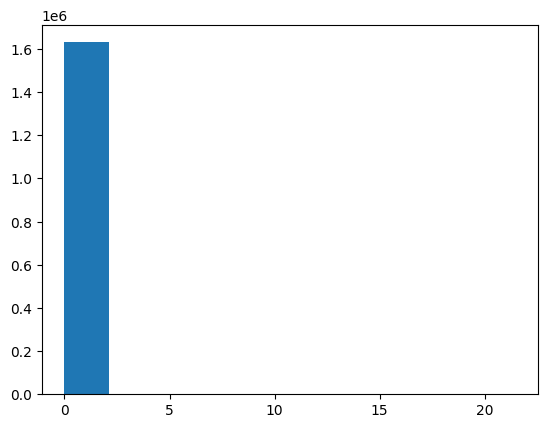

In [254]:
plt.hist(fdf['diff'])

### Extract frame number and indexes to calculate SOAP

In [300]:
error_df

,Unnamed: 0,frame,atom_idx,dft,mace,element,no_atoms,diff,TSNE_0,TSNE_1
0,4814,105,34,3.126624,4.301485,Ni,312,1.174861,46.022802,-41.923996
1,4844,105,64,-4.079446,-2.609252,Ni,312,1.470194,44.264795,-43.358377
2,4919,105,139,-13.371767,-12.305210,O,312,1.066557,-49.526758,-1.768618
3,4935,105,155,-7.930924,-6.742278,O,312,1.188646,0.859240,-51.001010
4,4941,105,161,0.875404,2.111908,O,312,1.236504,1.931036,-46.931815
...,...,...,...,...,...,...,...,...,...,...
1969,1605306,37153,46,1.453689,3.857184,O,48,2.403495,-116.952850,-48.991599
1970,1605307,37153,47,-1.390122,-3.229423,O,48,1.839301,-129.186515,11.047263
1971,1612944,37325,68,1.532312,0.436312,O,74,1.096000,-78.141200,91.646428
1972,1630189,37730,6,4.424876,5.475535,Ni,49,1.050659,77.063605,-33.649983


In [301]:
frames=list(error_df.groupby('frame')['atom_idx'].apply(list).keys())

In [302]:
idxs=list(error_df.groupby('frame')['atom_idx'].apply(list).values)

In [303]:
element=list(error_df.groupby('frame')['element'].apply(list).values)

In [314]:
elem_anal=[]
for i,id in enumerate(idxs):
    length=len(id)
    total_atoms=traj[frames[i]].get_number_of_atoms()
    total_energy=traj[frames[i]].todict()['info']['energy']
    mace_energy=traj[frames[i]].todict()['info']['MACE_energy']
    elem_anal.append((frames[i], element[i].count('Li'), element[i].count('Ni'),element[i].count('O'), 
                      length, total_atoms, total_energy, mace_energy, total_energy-mace_energy))
    

In [315]:
elemental_analysisdf=pd.DataFrame(elem_anal, columns=['frame', 'no_Li','no_Ni', 'no_O', 
                                                      'unfit_atom_no', 'total_atoms',
                                                     'total_ene', 'mace_ene', 'ene_diff'])

In [316]:
traj2=[]
for f in frames:
    traj2.append(copy.deepcopy(traj[f]))

In [317]:
elemental_analysisdf

,frame,no_Li,no_Ni,no_O,unfit_atom_no,total_atoms,total_ene,mace_ene,ene_diff
0,105,0,2,8,10,312,-3005.397438,-3002.490209,-2.907228
1,219,1,2,0,3,56,-521.177904,-521.377245,0.199341
2,382,0,1,1,2,104,-984.227479,-984.141354,-0.086125
3,748,0,4,8,12,19,-184.467131,-184.543976,0.076845
4,914,0,12,21,33,44,-420.926969,-446.110860,25.183891
...,...,...,...,...,...,...,...,...,...
127,36597,0,0,30,30,50,-464.389685,-478.568638,14.178952
128,36835,0,1,0,1,33,-323.764883,-323.696173,-0.068710
129,37153,0,0,30,30,48,-448.826520,-464.865370,16.038850
130,37325,0,0,1,1,74,-668.151855,-668.930753,0.778898


In [372]:
elemental_analysisdf['ratio_unfit_atoms']=(elemental_analysisdf['unfit_atom_no']/elemental_analysisdf['total_atoms'])*100

In [373]:
elemental_analysisdf

,frame,no_Li,no_Ni,no_O,unfit_atom_no,total_atoms,ratio_unfit_atoms
0,105,0,2,8,10,312,3.205128
1,219,1,2,0,3,56,5.357143
2,382,0,1,1,2,104,1.923077
3,748,0,4,8,12,19,63.157895
4,914,0,12,21,33,44,75.000000
...,...,...,...,...,...,...,...
127,36597,0,0,30,30,50,60.000000
128,36835,0,1,0,1,33,3.030303
129,37153,0,0,30,30,48,62.500000
130,37325,0,0,1,1,74,1.351351


In [424]:
(elemental_analysisdf[elemental_analysisdf['ratio_unfit_atoms'] > 40]['unfit_atom_no']).sum()

1476

<Axes: xlabel='frame', ylabel='ratio_unfit_atoms'>

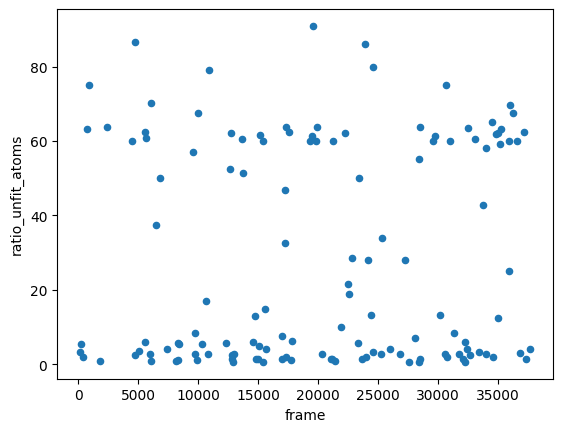

In [377]:
elemental_analysisdf.plot(x='frame', y='ratio_unfit_atoms', kind='scatter')

### Energy for problematic points

In [282]:
error_energy=[]
for a in set(error_df['frame']):
    error_energy.append(energy[a])

In [283]:
error_enedf=pd.DataFrame(error_energy, columns=['dft', 'mace'])

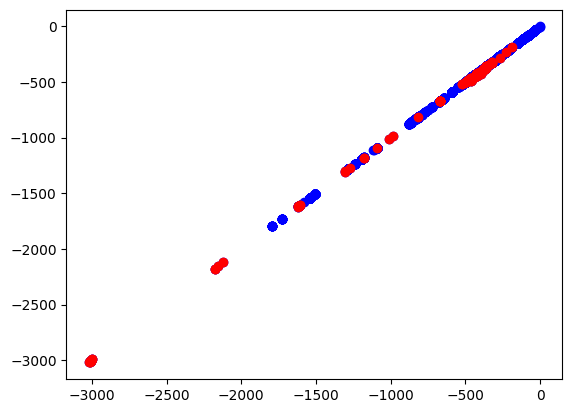

In [290]:
plt.scatter(x=ene_df['dft'], y=ene_df['mace'], color='b', label='df1')
plt.scatter(x=error_enedf['dft'], y=error_enedf['mace'], color='r', label='df2')

## Calculate SOAP for atoms with error in prediction more than 1 eV/A

In [360]:
so=CalculateSOAP(target_elements='auto')

In [361]:
so.fit(traj2)

CalculateSOAP(target_elements='auto')

In [362]:
error_soapdf=so.transform(traj2, indices=idxs)

In [363]:
error_soapdf

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,389
index,,,,,,,,,,,,,,,,,,,,,
0_Ni_34,1.392458e-04,-3.888661e-04,1.413094e-03,-1.599314e-03,0.001086,-0.003946,0.004466,0.014340,-0.016230,0.018369,...,0.000351,-0.000836,0.001787,-0.002783,0.001990,-0.004256,0.006634,0.009191,-0.014491,0.023174
0_Ni_64,4.194308e-05,-1.179129e-04,3.047027e-04,-2.780847e-04,0.000331,-0.000857,0.000782,0.002214,-0.002020,0.001844,...,0.000480,-0.001138,0.002302,-0.003319,0.002699,-0.005464,0.007887,0.011182,-0.016378,0.024459
0_O_139,1.254435e-04,-3.076983e-04,1.565460e-03,-2.119856e-03,0.000755,-0.003840,0.005200,0.019536,-0.026455,0.035823,...,0.000226,-0.000568,0.001168,0.001898,0.001428,-0.002914,-0.004888,0.006984,0.009332,0.024219
0_O_155,5.390974e-05,-1.507136e-04,3.659720e-04,-3.185736e-04,0.000421,-0.001023,0.000891,0.002484,-0.002163,0.001883,...,0.000264,-0.000657,0.001302,0.000836,0.001640,-0.003232,-0.002177,0.007936,0.006242,0.016520
0_O_161,6.654090e-06,-1.848852e-05,4.154480e-05,-3.381058e-05,0.000051,-0.000115,0.000094,0.000259,-0.000211,0.000172,...,0.000258,-0.000661,0.001246,0.002335,0.001691,-0.003194,-0.006055,0.006247,0.011698,0.026490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129_O_46,1.498046e-07,-4.143203e-07,8.901132e-07,-6.946374e-07,0.000001,-0.000002,0.000002,0.000005,-0.000004,0.000003,...,0.000285,-0.000729,0.000896,0.003359,0.001868,-0.002295,-0.008604,0.002819,0.010567,0.039637
129_O_47,4.389998e-06,9.652897e-06,1.319387e-04,-2.992147e-04,0.000021,0.000290,-0.000658,0.003965,-0.008993,0.020394,...,0.000280,-0.000718,0.000882,0.003305,0.001838,-0.002258,-0.008465,0.002773,0.010396,0.038998
130_O_68,1.085258e-04,-5.159670e-05,2.310733e-03,-4.431746e-03,0.000025,-0.001099,0.002107,0.049200,-0.094361,0.180974,...,0.000281,-0.000724,0.001073,0.003137,0.001864,-0.002761,-0.008080,0.004156,0.011860,0.035634


## Visualize

In [368]:
from structure_search.utils.VisualizeMatches import VisualizeMatchesfromTraj
vis=VisualizeMatchesfromTraj()

In [371]:
vis.visualize(idx_list=list(error_soapdf.index), traj=traj2, method='SOAP', local_environment=True)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 312, "names": ["Li", "Li", "Li", "Li", …

## TSNE

In [379]:
from openTSNE import TSNE

In [380]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    metric="euclidean",
    n_jobs=25,
    random_state=42,
    verbose=False,
)
env_embedding=tsne.fit(error_soapdf.to_numpy())

In [382]:
error_soapdf['TSNE_0']=env_embedding[:,0]
error_soapdf['TSNE_1']=env_embedding[:,1]

In [384]:
error_df['TSNE_0']=env_embedding[:,0]
error_df['TSNE_1']=env_embedding[:,1]

In [385]:
error_df.columns

Index(['frame', 'atom_idx', 'dft', 'mace', 'element', 'no_atoms', 'diff',
       'TSNE_0', 'TSNE_1'],
      dtype='object')

## Chemiscope

In [383]:
from chemiscope import write_input

In [403]:
envs=tuple(zip(list(error_df['frame']), list(error_df['atom_idx']), [4.5]*1974))

In [410]:
properties={}
for prop in ['TSNE_0', 'TSNE_1', 'dft', 'mace', 'element', 'diff']:
    properties[prop]={"target":"atom","values":error_df[prop].values}


write_input("./error-atom.json.gz", frames=traj,
            environments=list(envs),
            properties=properties)
from IPython.display import FileLink
FileLink("./error-atom.json.gz")

/gpfs/projects/qm_inorganics/sheena_q2/ipynbs/error-atom.json.gz

## Calculate SOAP for all

In [418]:
all_soapdf=so.transform(traj)

In [440]:
tsne = TSNE(
    n_components=2,
    perplexity=100,
    metric="euclidean",
    n_jobs=-1,
    random_state=42,
    verbose=True,
)
env_embedding=tsne.fit(all_soapdf.to_numpy())

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, perplexity=100, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 300 nearest neighbors using Annoy approximate search using euclidean distance...


KeyboardInterrupt: 

In [421]:
len(env_embedding)

1974

In [426]:
fdf['TSNE_0']=env_embedding[:,0]
fdf['TSNE_1']=env_embedding[:,1]

In [427]:
fdf

,frame,atom_idx,dft,mace,element,no_atoms,diff,TSNE_0,TSNE_1
0,0,0,-0.001696,-0.042027,Li,47,0.040331,10.212128,94.639307
1,0,1,-0.000766,-0.074013,Li,47,0.073247,11.543744,54.900842
2,0,2,-0.003454,-0.105438,Li,47,0.101984,9.133397,57.262652
3,0,3,-0.000510,-0.079769,Li,47,0.079259,40.899679,67.894899
4,0,4,-0.001658,-0.005400,Li,47,0.003742,9.685468,69.372351
...,...,...,...,...,...,...,...,...,...
1630655,37742,19,0.009548,-0.031147,O,24,0.040695,1.600814,75.501678
1630656,37742,20,0.004859,-0.102516,O,24,0.107375,-4.465645,73.945653
1630657,37742,21,0.011142,0.081655,O,24,0.070513,-72.310688,103.741664
1630658,37742,22,0.014228,0.055438,O,24,0.041210,-1.300041,71.434343


In [473]:
fdf.to_csv('../sabrina_data/full-df.csv')
error_df.to_csv('../sabrina_data/error-df.csv')
error_soapdf.to_csv('../sabrina_data/error-soapdf.csv')
all_soapdf.to_csv('../sabrina_data/all-soapdf.csv')

In [318]:
elemental_analysisdf.to_csv('../sabrina_data/elemental_analysisdf.csv')

In [428]:
properties={}
for prop in ['TSNE_0', 'TSNE_1', 'dft', 'mace', 'element', 'diff']:
    properties[prop]={"target":"atom","values":fdf[prop].values}


write_input("./all-atom.json.gz", frames=traj,
            properties=properties)
from IPython.display import FileLink
FileLink("./all-atom.json.gz")

/gpfs/projects/qm_inorganics/sheena_q2/ipynbs/all-atom.json.gz

## Plot selected atoms on top of all

In [438]:
Ni_df=error_df[error_df['element']=='Ni']
O_df=error_df[error_df['element']=='O']
Li_df=error_df[error_df['element']=='Li']

In [455]:
all_Ni_df=fdf[fdf['element']=='Ni']
all_O_df=fdf[fdf['element']=='O']
all_Li_df=fdf[fdf['element']=='Li']

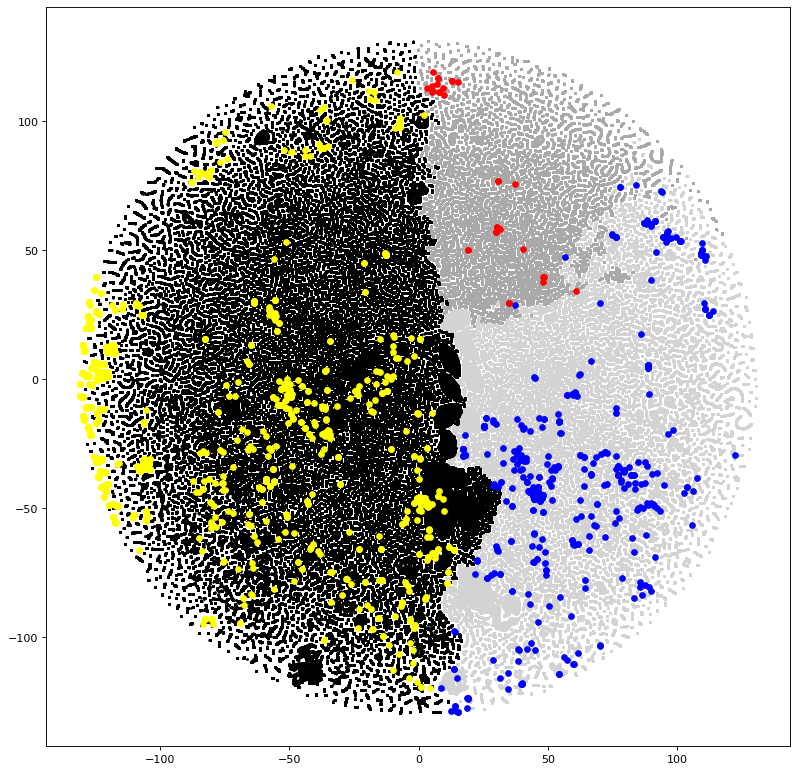

In [457]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(12, 12), dpi=80)
figure=plt.scatter(x=all_Ni_df['TSNE_0'],y=all_Ni_df['TSNE_1'], c='lightgray', s=5,linewidths=0)
figure=plt.scatter(x=all_Li_df['TSNE_0'],y=all_Li_df['TSNE_1'], c='darkgray', s=5,linewidths=0)
figure=plt.scatter(x=all_O_df['TSNE_0'],y=all_O_df['TSNE_1'], c='black', s=5,linewidths=0)
figure=plt.plot(Ni_df['TSNE_0'],Ni_df['TSNE_1'],marker='o', ms=5, color='blue', lw=0)
figure=plt.plot(Li_df['TSNE_0'],Li_df['TSNE_1'],marker='o', ms=5, color='red', lw=0)
figure=plt.plot(O_df['TSNE_0'],O_df['TSNE_1'],marker='o', ms=5, color='yellow', lw=0)

figure

## PCA

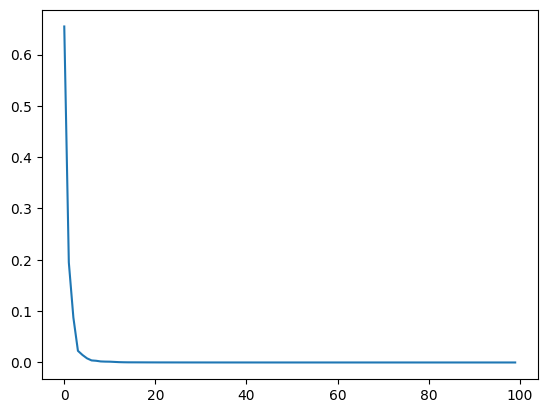

In [441]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=PCA(n_components=100)
pca.fit(all_soapdf.to_numpy())
plt.plot(pca.explained_variance_ratio_)

In [442]:
n_comp=np.max(np.where(pca.explained_variance_ratio_>0.001)[0])
n_comp

11

In [443]:
soapdesc_pca=pca.transform(all_soapdf.to_numpy())[:,0:n_comp]
np.shape(soapdesc_pca)

(1630660, 11)

In [444]:
import seaborn as sns 
sns.reset_orig()
descdf=pd.DataFrame({'PC_{}'.format(i): soapdesc_pca[:,i] for i in range(len(soapdesc_pca[0]))})

In [445]:
descdf

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,0.274540,0.527820,0.143155,-0.003100,-0.071346,0.001103,0.042704,-0.071749,0.020428,0.004592,0.000942
1,0.278497,0.525236,0.088236,-0.007181,-0.046585,-0.001519,0.022935,-0.056426,0.005710,-0.001864,-0.002502
2,0.279867,0.524974,0.088975,-0.008147,-0.046598,-0.000361,0.022474,-0.056718,0.005980,-0.002333,-0.001779
3,0.288504,0.520060,0.142274,-0.010537,-0.067833,0.025353,0.028743,-0.076615,0.016029,-0.001906,0.011422
4,0.279487,0.525340,0.151565,-0.003926,-0.071846,0.014654,0.039064,-0.075769,0.020925,0.000511,0.006450
...,...,...,...,...,...,...,...,...,...,...,...
1630655,-0.317953,0.016168,0.268347,0.033046,0.077043,-0.011338,0.006210,0.003940,0.027339,0.025366,0.013433
1630656,-0.318068,0.015623,0.264672,0.032946,0.077745,-0.012160,0.005550,0.003505,0.028132,0.022393,0.012407
1630657,-0.319095,0.009118,0.269956,0.036138,0.052402,0.007408,0.003544,0.005416,0.002071,0.051723,0.020450
1630658,-0.317645,0.016244,0.266658,0.033039,0.077224,-0.012317,0.005984,0.003541,0.027710,0.024225,0.013238


In [446]:
descdf['center']=fdf.element.values

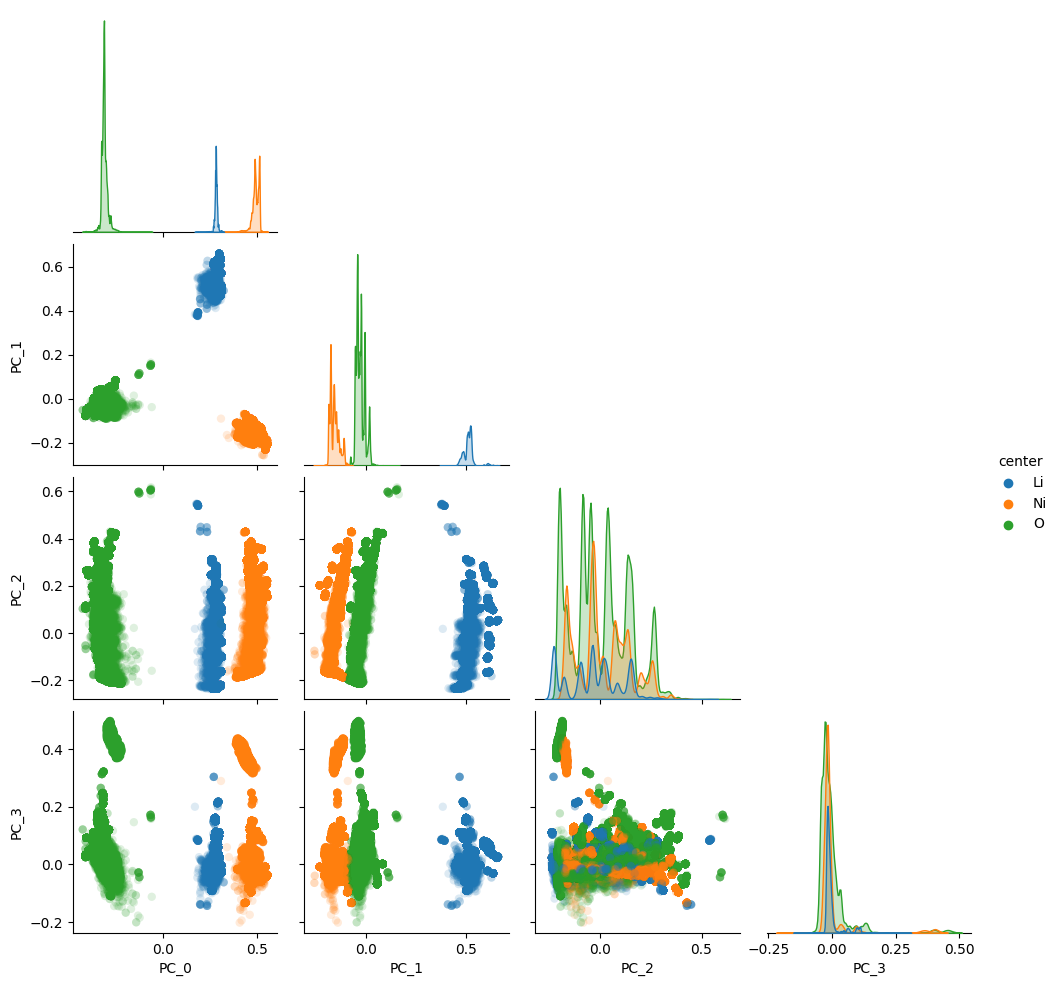

In [447]:
fig=sns.pairplot(descdf[[*descdf.columns[0:4],'center']],hue='center',height=2.5,plot_kws=dict( linewidth=0,alpha=0.15),corner=True)

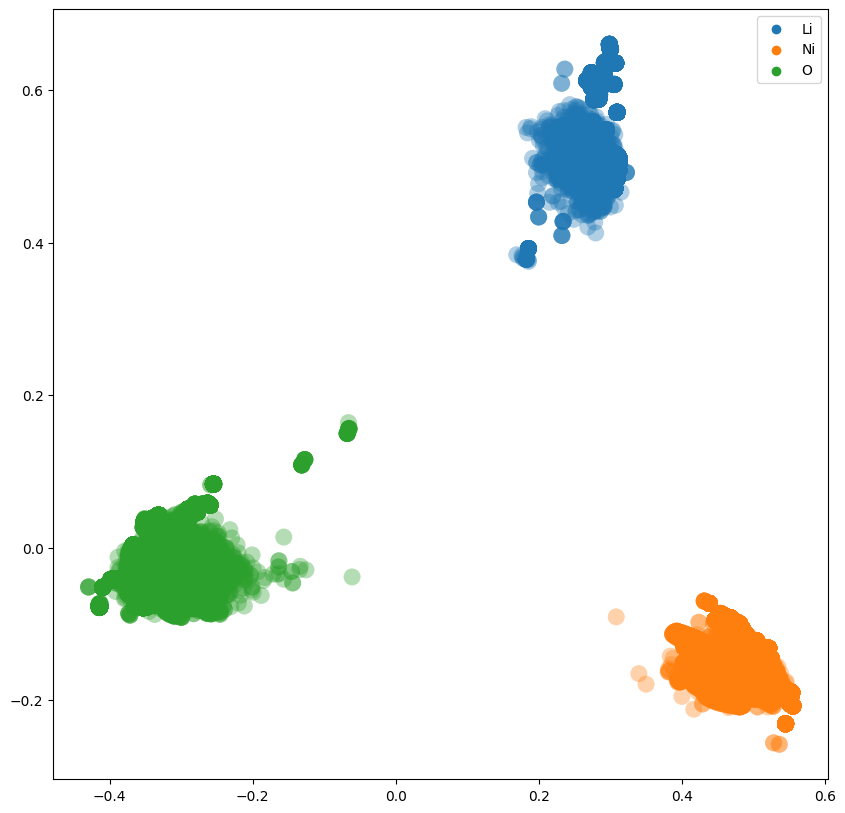

In [454]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=soapdesc_pca[:,0], y=soapdesc_pca[:,1],hue=fdf.element.values,linewidth=0,
                alpha=0.35,s= 150)
plt.savefig('PCA_atoms.svg')


## Similarity

### Train ANNOY

In [197]:
all_soapdf=pd.read_csv('../sabrina_data/all-soapdf.csv')
error_df=pd.read_csv('../sabrina_data/error-df.csv')
fdf=pd.read_csv('../sabrina_data/full-df.csv')

In [345]:
error_labels=list(error_df['Unnamed: 0'])
error_soapdf=all_soapdf.iloc[error_labels]

In [346]:
error_soapdf

,0,1,2,3,4,5,6,7,8,9,...,383,384,385,386,387,388,389,dftf,macef,difff
index,,,,,,,,,,,,,,,,,,,,,
105_Ni_34,1.392458e-04,-3.888661e-04,1.413094e-03,-1.599314e-03,0.001086,-0.003946,0.004466,0.014340,-0.016230,0.018369,...,-0.002783,0.001990,-0.004256,0.006634,0.009191,-0.014491,0.023174,3.126624,4.301485,1.174861
105_Ni_64,4.194308e-05,-1.179129e-04,3.047027e-04,-2.780847e-04,0.000331,-0.000857,0.000782,0.002214,-0.002020,0.001844,...,-0.003319,0.002699,-0.005464,0.007887,0.011182,-0.016378,0.024459,-4.079446,-2.609252,1.470194
105_O_139,1.254435e-04,-3.076983e-04,1.565460e-03,-2.119856e-03,0.000755,-0.003840,0.005200,0.019536,-0.026455,0.035823,...,0.001898,0.001428,-0.002914,-0.004888,0.006984,0.009332,0.024219,-13.371767,-12.305210,1.066557
105_O_155,5.390974e-05,-1.507136e-04,3.659720e-04,-3.185736e-04,0.000421,-0.001023,0.000891,0.002484,-0.002163,0.001883,...,0.000836,0.001640,-0.003232,-0.002177,0.007936,0.006242,0.016520,-7.930924,-6.742278,1.188646
105_O_161,6.654090e-06,-1.848852e-05,4.154480e-05,-3.381058e-05,0.000051,-0.000115,0.000094,0.000259,-0.000211,0.000172,...,0.002335,0.001691,-0.003194,-0.006055,0.006247,0.011698,0.026490,0.875404,2.111908,1.236504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37153_O_46,1.498046e-07,-4.143203e-07,8.901132e-07,-6.946374e-07,0.000001,-0.000002,0.000002,0.000005,-0.000004,0.000003,...,0.003359,0.001868,-0.002295,-0.008604,0.002819,0.010567,0.039637,1.453689,3.857184,2.403495
37153_O_47,4.389998e-06,9.652897e-06,1.319387e-04,-2.992147e-04,0.000021,0.000290,-0.000658,0.003965,-0.008993,0.020394,...,0.003305,0.001838,-0.002258,-0.008465,0.002773,0.010396,0.038998,-1.390122,-3.229423,1.839301
37325_O_68,1.085258e-04,-5.159670e-05,2.310733e-03,-4.431746e-03,0.000025,-0.001099,0.002107,0.049200,-0.094361,0.180974,...,0.003137,0.001864,-0.002761,-0.008080,0.004156,0.011860,0.035634,1.532312,0.436312,1.096000


In [199]:
error_soapdf.set_index('index', inplace=True)
all_soapdf.set_index('index', inplace=True)

In [200]:
annoy=AnnoySearch() 
#annoy.fit(all_soapdf, n_trees=10)

In [201]:
matches, distance=annoy.transform(error_soapdf, modelfile='../sabrina_data/Annoy.model', n_neighbors=100)

In [202]:
all_soapdf['dftf']=list(fdf['dft'])
all_soapdf['macef']=list(fdf['mace'])
all_soapdf['difff']=list(fdf['diff'])
error_soapdf['dftf']=list(error_df['dft'])
error_soapdf['macef']=list(error_df['mace'])
error_soapdf['difff']=list(error_df['diff'])

In [227]:
matches_df=[]
for j,match in enumerate(matches):
    for i,m in enumerate(match):
        if all_soapdf.index[m] in error_soapdf.index:
            matches_df.append((all_soapdf.index[m], error_soapdf.index[j],distance[j][i], 
                               "error_atom", 
                               all_soapdf.dftf[m], all_soapdf.macef[m], all_soapdf.difff[m],
                               error_soapdf.dftf[j], error_soapdf.macef[j], error_soapdf.difff[j]))
        else:
            matches_df.append((all_soapdf.index[m], error_soapdf.index[j],distance[j][i], 
                               "non-error_atom", 
                               all_soapdf.dftf[m], all_soapdf.macef[m], all_soapdf.difff[m],
                               error_soapdf.dftf[j], error_soapdf.macef[j], error_soapdf.difff[j]))

In [228]:
match_df=pd.DataFrame(matches_df, columns=['match-index', 'query-index', 'distance', 'tag', 
                                           'dft_force', 'mace_force', 'diff',
                                          'e-dft_force', 'e-mace_force', 'e-diff',])

In [229]:
match_df.value_counts('tag')

tag
non-error_atom    177580
error_atom         19820
Name: count, dtype: int64

## Top 10 matches

In [230]:
all_soapdf=pd.read_csv('../sabrina_data/all-soapdf.csv')
error_df=pd.read_csv('../sabrina_data/error-df.csv')
fdf=pd.read_csv('../sabrina_data/full-df.csv')

error_labels=list(error_df['Unnamed: 0'])
error_soapdf=all_soapdf.iloc[error_labels]

error_soapdf.set_index('index', inplace=True)
all_soapdf.set_index('index', inplace=True)

In [231]:
matches, distance=annoy.transform(error_soapdf, modelfile='../sabrina_data/Annoy.model', n_neighbors=10)

In [232]:
all_soapdf['dftf']=list(fdf['dft'])
all_soapdf['macef']=list(fdf['mace'])
all_soapdf['difff']=list(fdf['diff'])
error_soapdf['dftf']=list(error_df['dft'])
error_soapdf['macef']=list(error_df['mace'])
error_soapdf['difff']=list(error_df['diff'])

In [233]:
matches_df=[]
for j,match in enumerate(matches):
    for i,m in enumerate(match):
        if all_soapdf.index[m] in error_soapdf.index:
            matches_df.append((all_soapdf.index[m], error_soapdf.index[j],distance[j][i], 
                               "error_atom", 
                               all_soapdf.dftf[m], all_soapdf.macef[m], all_soapdf.difff[m],
                               error_soapdf.dftf[j], error_soapdf.macef[j], error_soapdf.difff[j]))
        else:
            matches_df.append((all_soapdf.index[m], error_soapdf.index[j],distance[j][i], 
                               "non-error_atom", 
                               all_soapdf.dftf[m], all_soapdf.macef[m], all_soapdf.difff[m],
                               error_soapdf.dftf[j], error_soapdf.macef[j], error_soapdf.difff[j]))

In [234]:
match_df10=pd.DataFrame(matches_df, columns=['match-index', 'query-index', 'distance', 'tag', 
                                           'dft_force', 'mace_force', 'diff',
                                          'e-dft_force', 'e-mace_force', 'e-diff',])

In [235]:
match_df10.value_counts('tag')

tag
non-error_atom    15654
error_atom         4086
Name: count, dtype: int64

In [461]:
match_df10

,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff
0,105_Ni_34,105_Ni_34,0.000000,error_atom,3.126624,4.301485,1.174861,3.126624,4.301485,1.174861
1,30735_Ni_48,105_Ni_34,0.029842,non-error_atom,2.032517,2.059902,0.027385,3.126624,4.301485,1.174861
2,24445_Ni_59,105_Ni_34,0.036245,non-error_atom,0.892040,0.207282,0.684758,3.126624,4.301485,1.174861
3,30162_Ni_59,105_Ni_34,0.036245,non-error_atom,0.892040,0.207282,0.684758,3.126624,4.301485,1.174861
4,33452_Ni_95,105_Ni_34,0.037081,non-error_atom,-0.626346,-0.655897,0.029551,3.126624,4.301485,1.174861
...,...,...,...,...,...,...,...,...,...,...
19735,15981_Ni_14,37730_Ni_14,0.025043,non-error_atom,0.847792,0.788432,0.059360,4.796293,6.057925,1.261632
19736,6384_Ni_14,37730_Ni_14,0.025858,non-error_atom,0.571907,0.663532,0.091625,4.796293,6.057925,1.261632
19737,15910_Ni_14,37730_Ni_14,0.026265,non-error_atom,0.632964,0.602144,0.030820,4.796293,6.057925,1.261632
19738,29789_Ni_14,37730_Ni_14,0.026467,non-error_atom,0.593704,0.572197,0.021507,4.796293,6.057925,1.261632


### Finding out envs and frames with dissimilar env

In [543]:
query_dist_list=match_df10.groupby('query-index')['distance'].apply(list)

In [588]:
similarity_analysis=[]
for i,dists in enumerate(query_dist_list):
    val=sum(i >= 0.03 for i in dists)
    similarity_analysis.append((query_dist_list.index[i], val))

similarity_analysisdf=pd.DataFrame(similarity_analysis, columns=['query_index', 'high_dist_count'])

In [627]:
similarity_analysisdf

,high_dist_count
query_index,
10026_Ni_10,0
10026_Ni_15,0
10026_Ni_5,0
10026_Ni_9,0
10026_O_18,0
...,...
9762_O_28,2
9762_O_29,6
9762_O_38,2


In [619]:
simi_df=similarity_analysisdf.merge(fdf, left_index=True, right_index=True)

In [631]:
simi_df['diff']=abs(simi_df['dft']-simi_df['mace'])

In [651]:
list(simi_df[simi_df['diff']>=3]['high_dist_count']).count(8)

4

In [620]:
simi_df[simi_df['high_dist_count']==0]

,high_dist_count,frame,atom_idx,dft,mace,element,no_atoms,magmom
10026_Ni_10,0,10026,10,-1.035187,-0.016372,Ni,46,1.871
10026_Ni_15,0,10026,15,1.084477,-0.269345,Ni,46,1.880
10026_Ni_5,0,10026,5,0.746002,-0.426683,Ni,46,1.859
10026_Ni_9,0,10026,9,-1.709706,-0.337131,Ni,46,1.870
10026_O_18,0,10026,18,-1.384620,-3.856488,O,46,0.800
...,...,...,...,...,...,...,...,...
9585_O_33,0,9585,33,-1.457812,-3.400411,O,35,0.795
9585_O_34,0,9585,34,-1.552772,-3.512485,O,35,0.667
9753_O_68,0,9753,68,1.356433,0.083304,O,74,-0.033
9753_O_71,0,9753,71,-1.095050,-0.061268,O,74,0.043


In [621]:
for a in [0,1,2,3,4,5,6,7,8]:
    print(a+1, len(simi_df[(simi_df['high_dist_count'] <=a+1) & (simi_df['high_dist_count'] > a)]))

1 0
2 4
3 1
4 0
5 2
6 5
7 7
8 103
9 171


In [623]:
higher_8_df=simi_df[(simi_df['high_dist_count'] >= 8)]

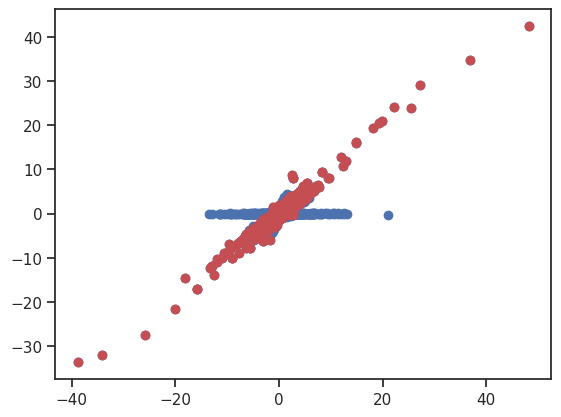

In [654]:
plt.scatter(x=simi_df['dft'], y=simi_df['mace'], color='b', label='df1')
plt.scatter(x=higher_8_df['dft'], y=higher_8_df['mace'], color='r', label='df2')


<Axes: xlabel='dft', ylabel='mace'>

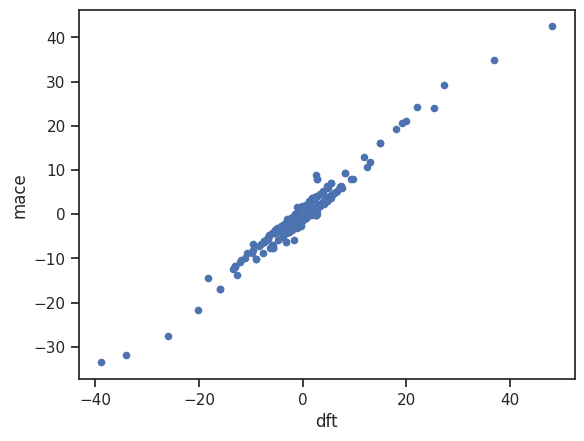

In [630]:
higher_8_df.plot(x='dft', y='mace', kind='scatter')

In [597]:
dis_idx=list(similarity_analysisdf[(similarity_analysisdf['high_dist_count'] >= 8)]['query_index'])

In [605]:
idx=list(all_soapdf.index)
fdf['index']=idx
fdf.set_index('index', inplace=True)
similarity_analysisdf.set_index('query_index', inplace=True)

In [502]:
match_df10.iloc[10:20,]

,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff,query_index
10,105_Ni_64,105_Ni_64,0.000000,error_atom,-4.079446,-2.609252,1.470194,-4.079446,-2.609252,1.470194,31310_Ni_6
11,17340_Ni_112,105_Ni_64,0.053751,non-error_atom,2.539961,3.266910,0.726949,-4.079446,-2.609252,1.470194,31310_Ni_6
12,14770_Ni_112,105_Ni_64,0.054621,non-error_atom,-0.374971,-0.300282,0.074689,-4.079446,-2.609252,1.470194,31310_Ni_6
13,17340_Ni_27,105_Ni_64,0.066245,non-error_atom,-2.900166,-3.279962,0.379796,-4.079446,-2.609252,1.470194,31310_Ni_6
14,24445_Ni_66,105_Ni_64,0.066555,non-error_atom,-0.479195,-0.720965,0.241770,-4.079446,-2.609252,1.470194,31310_Ni_6
15,30162_Ni_66,105_Ni_64,0.066555,non-error_atom,-0.479195,-0.720965,0.241770,-4.079446,-2.609252,1.470194,31310_Ni_6
16,17340_Ni_47,105_Ni_64,0.073004,non-error_atom,2.308542,2.355799,0.047257,-4.079446,-2.609252,1.470194,31310_Ni_6
17,24619_Ni_114,105_Ni_64,0.073285,non-error_atom,2.801229,2.275259,0.525970,-4.079446,-2.609252,1.470194,31310_Ni_6
18,24445_Ni_82,105_Ni_64,0.077918,non-error_atom,-0.679271,-1.331434,0.652163,-4.079446,-2.609252,1.470194,31310_Ni_6
19,30162_Ni_82,105_Ni_64,0.077918,non-error_atom,-0.679271,-1.331434,0.652163,-4.079446,-2.609252,1.470194,31310_Ni_6


In [503]:
vis.visualize(idx_list=list(match_df10.loc[10:20, 'match-index']), traj=traj, method='SOAP', local_environment=True)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 312, "names": ["Li", "Li", "Li", "Li", …

In [504]:
vis.visualize(idx_list=list(match_df10.loc[10:20, 'match-index']), traj=traj, method='SOAP', local_environment=True)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 312, "names": ["Li", "Li", "Li", "Li", …

(array([1.777e+04, 9.700e+02, 6.200e+02, 1.400e+02, 1.100e+02, 1.100e+02,
        1.000e+01, 0.000e+00, 0.000e+00, 1.000e+01]),
 array([ 1.00002364,  3.04497469,  5.08992573,  7.13487678,  9.17982782,
        11.22477887, 13.26972992, 15.31468096, 17.35963201, 19.40458305,
        21.4495341 ]),
 <BarContainer object of 10 artists>)

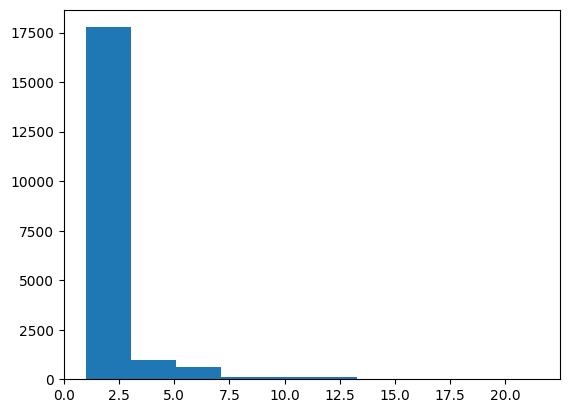

In [245]:
plt.hist(match_df10['e-diff'])

(array([1.7669e+04, 1.5370e+03, 3.7800e+02, 7.5000e+01, 4.2000e+01,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+01, 8.0000e+00]),
 array([0.        , 0.04154947, 0.08309895, 0.12464842, 0.1661979 ,
        0.20774737, 0.24929684, 0.29084632, 0.33239579, 0.37394527,
        0.41549474]),
 <BarContainer object of 10 artists>)

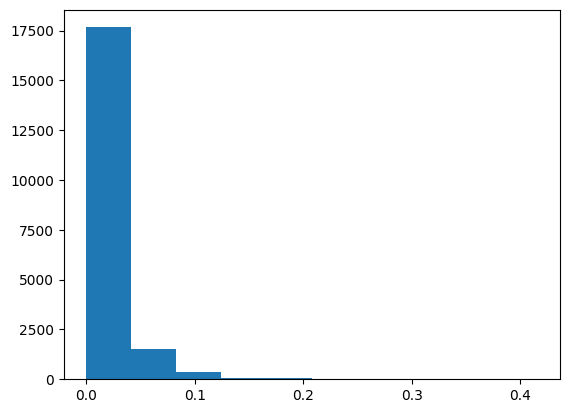

In [260]:
plt.hist(match_df10['distance'])

In [247]:
very_high_force_df=match_df10[match_df10['e-diff']> 3]

In [267]:
very_high_force_df.reset_index(inplace=True)

In [250]:
len(set(very_high_force_df['query-index']))

200

In [251]:
very_high_force_df.value_counts('tag')

tag
non-error_atom    1636
error_atom         364
Name: count, dtype: int64

In [272]:
very_high_force_df[very_high_force_df['diff']>5]

,index,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff
0,270,914_Ni_2,914_Ni_2,0.0,error_atom,-10.578418,-0.063099,10.515319,-10.578418,-0.063099,10.515319
10,280,914_Ni_3,914_Ni_3,0.0,error_atom,-6.727602,-0.097743,6.629859,-6.727602,-0.097743,6.629859
30,300,914_Ni_6,914_Ni_6,0.0,error_atom,9.261384,0.114456,9.146928,9.261384,0.114456,9.146928
40,310,914_Ni_7,914_Ni_7,0.0,error_atom,8.207423,0.022578,8.184845,8.207423,0.022578,8.184845
60,370,914_Ni_14,914_Ni_14,0.0,error_atom,-8.506290,-0.030281,8.476009,-8.506290,-0.030281,8.476009
...,...,...,...,...,...,...,...,...,...,...,...
1710,12550,24581_O_49,24581_O_49,0.0,error_atom,-5.108186,0.012701,5.120887,-5.108186,0.012701,5.120887
1750,14710,24445_O_195,30162_O_195,0.0,error_atom,2.746368,7.986158,5.239790,2.746368,7.986158,5.239790
1751,14711,30162_O_195,30162_O_195,0.0,error_atom,2.746368,7.986158,5.239790,2.746368,7.986158,5.239790
1830,14970,30642_Ni_15,30642_Ni_15,0.0,error_atom,5.619555,-0.000349,5.619904,5.619555,-0.000349,5.619904


(array([1923.,   10.,   15.,   20.,    5.,   11.,    0.,    0.,    2.,
          14.]),
 array([0.        , 0.03573493, 0.07146987, 0.1072048 , 0.14293973,
        0.17867467, 0.2144096 , 0.25014454, 0.28587947, 0.3216144 ,
        0.35734934]),
 <BarContainer object of 10 artists>)

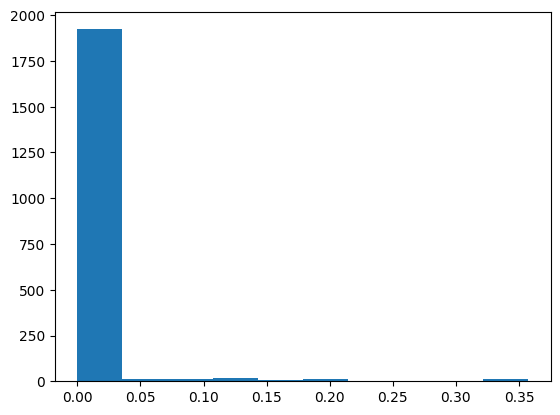

In [271]:
plt.hist(very_high_force_df['distance'])

## Visualize matches from traj

In [269]:
from structure_search.utils.VisualizeMatches import VisualizeMatchesfromTraj
vis=VisualizeMatchesfromTraj()

In [273]:
very_high_force_df.iloc[270:280,:]

,index,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff
270,1380,4765_O_13,4765_O_13,0.000000e+00,error_atom,3.455313,0.032197,3.423116,3.455313,0.032197,3.423116
271,1381,14280_O_13,4765_O_13,6.476981e-08,non-error_atom,-0.004787,0.032197,0.036984,3.455313,0.032197,3.423116
272,1382,22072_O_23,4765_O_13,1.268049e-04,non-error_atom,0.003517,-0.032944,0.036461,3.455313,0.032197,3.423116
273,1383,28567_O_13,4765_O_13,1.285371e-04,non-error_atom,-0.019280,0.030458,0.049738,3.455313,0.032197,3.423116
274,1384,27059_O_13,4765_O_13,1.320347e-04,non-error_atom,-0.029650,0.025440,0.055090,3.455313,0.032197,3.423116
275,1385,28567_O_23,4765_O_13,1.340703e-04,non-error_atom,0.012771,-0.033511,0.046282,3.455313,0.032197,3.423116
276,1386,5296_O_13,4765_O_13,1.513747e-04,non-error_atom,-0.014628,0.027352,0.041980,3.455313,0.032197,3.423116
277,1387,2436_O_13,4765_O_13,1.722261e-04,non-error_atom,-0.000037,0.032802,0.032839,3.455313,0.032197,3.423116
278,1388,4765_O_23,4765_O_13,1.732572e-04,error_atom,-4.687814,-0.037032,4.650782,3.455313,0.032197,3.423116
279,1389,14280_O_23,4765_O_13,1.732594e-04,non-error_atom,0.001123,-0.037032,0.038155,3.455313,0.032197,3.423116


In [270]:
vis.visualize(idx_list=list(very_high_force_df['match-index']), traj=traj, method='SOAP', local_environment=True)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 44, "names": ["Li", "Li", "Ni", "Ni", "…

In [291]:
very_high_force_df[very_high_force_df['distance']>0.3]

,index,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff
1372,12102,24619_O_233,24445_O_232,0.315352,non-error_atom,-0.351640,0.168776,0.520416,-3.118418,-6.251744,3.133326
1373,12103,23615_O_18,24445_O_232,0.339367,non-error_atom,2.280773,2.749023,0.468250,-3.118418,-6.251744,3.133326
1374,12104,12891_O_150,24445_O_232,0.345085,non-error_atom,-0.517622,-0.828517,0.310895,-3.118418,-6.251744,3.133326
1375,12105,14770_O_172,24445_O_232,0.345837,error_atom,-4.064459,-5.229363,1.164904,-3.118418,-6.251744,3.133326
1376,12106,1968_O_132,24445_O_232,0.354674,non-error_atom,-0.569058,-0.061412,0.507646,-3.118418,-6.251744,3.133326
1377,12107,29872_O_96,24445_O_232,0.356530,non-error_atom,-2.203711,-2.314611,0.110900,-3.118418,-6.251744,3.133326
1378,12108,9762_O_20,24445_O_232,0.357349,non-error_atom,3.707393,4.016152,0.308759,-3.118418,-6.251744,3.133326
1379,12109,31310_O_20,24445_O_232,0.357349,non-error_atom,3.707393,4.016152,0.308759,-3.118418,-6.251744,3.133326
1762,14782,24619_O_233,30162_O_232,0.315352,non-error_atom,-0.351640,0.168776,0.520416,-3.118418,-6.251744,3.133326
1763,14783,23615_O_18,30162_O_232,0.339367,non-error_atom,2.280773,2.749023,0.468250,-3.118418,-6.251744,3.133326


In [292]:
vis.visualize(idx_list=list(very_high_force_df['match-index']), traj=traj, method='SOAP', local_environment=True)

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 44, "names": ["Li", "Li", "Ni", "Ni", "…

In [293]:
very_high_force_df

,index,match-index,query-index,distance,tag,dft_force,mace_force,diff,e-dft_force,e-mace_force,e-diff
0,270,914_Ni_2,914_Ni_2,0.000000e+00,error_atom,-10.578418,-0.063099,10.515319,-10.578418,-0.063099,10.515319
1,271,27575_Ni_2,914_Ni_2,0.000000e+00,non-error_atom,-0.035556,-0.063099,0.027543,-10.578418,-0.063099,10.515319
2,272,6373_Ni_2,914_Ni_2,2.072349e-08,non-error_atom,-0.035623,-0.063099,0.027476,-10.578418,-0.063099,10.515319
3,273,26765_Ni_2,914_Ni_2,3.788433e-08,non-error_atom,-0.035720,-0.063098,0.027378,-10.578418,-0.063099,10.515319
4,274,23173_Ni_2,914_Ni_2,1.039421e-07,non-error_atom,-0.035868,-0.063101,0.027233,-10.578418,-0.063099,10.515319
...,...,...,...,...,...,...,...,...,...,...,...
1995,19045,26418_O_44,36286_O_31,1.376799e-03,non-error_atom,-0.017359,-0.008403,0.008956,-3.401965,-0.018510,3.383455
1996,19046,11246_O_34,36286_O_31,1.384146e-03,non-error_atom,-0.004144,0.002046,0.006190,-3.401965,-0.018510,3.383455
1997,19047,6303_O_34,36286_O_31,1.385630e-03,non-error_atom,-0.003388,0.002238,0.005626,-3.401965,-0.018510,3.383455
1998,19048,15586_O_34,36286_O_31,1.392064e-03,non-error_atom,0.002561,0.002028,0.000533,-3.401965,-0.018510,3.383455


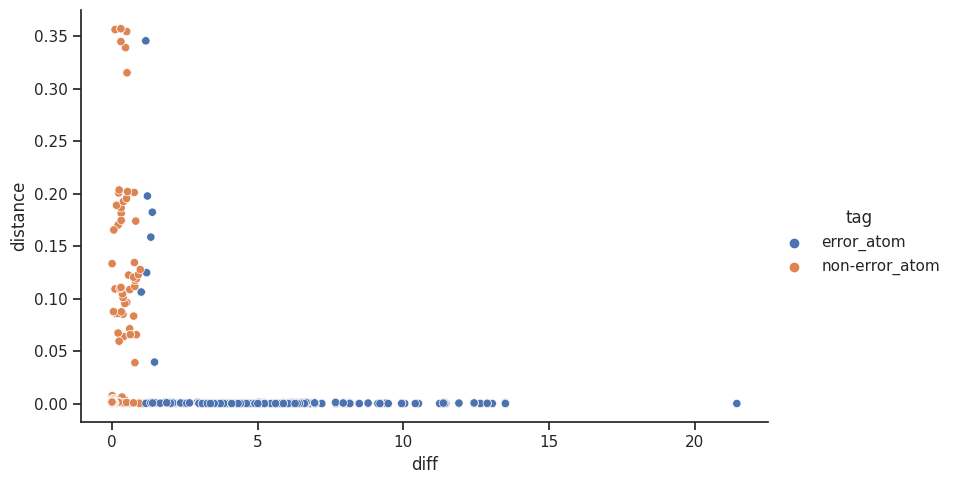

In [393]:
sns.relplot(data=very_high_force_df, x='diff', y='distance', hue='tag',aspect=1.61)
plt.show()

## Structural level analysis

In [319]:
elemental_analysisdf=pd.read_csv('../sabrina_data/elemental_analysisdf.csv')

In [342]:
elemental_analysisdf.set_index('frame', inplace=True)

In [343]:
elemental_analysisdf

,Unnamed: 0,no_Li,no_Ni,no_O,unfit_atom_no,total_atoms,total_ene,mace_ene,ene_diff
frame,,,,,,,,,
105,0,0,2,8,10,312,-3005.397438,-3002.490209,-2.907228
219,1,1,2,0,3,56,-521.177904,-521.377245,0.199341
382,2,0,1,1,2,104,-984.227479,-984.141354,-0.086125
748,3,0,4,8,12,19,-184.467131,-184.543976,0.076845
914,4,0,12,21,33,44,-420.926969,-446.110860,25.183891
...,...,...,...,...,...,...,...,...,...
36597,127,0,0,30,30,50,-464.389685,-478.568638,14.178952
36835,128,0,1,0,1,33,-323.764883,-323.696173,-0.068710
37153,129,0,0,30,30,48,-448.826520,-464.865370,16.038850


### SOAP

In [325]:
so=CalculateSOAP(target_elements='auto')

In [327]:
so.fit(traj2, site_to_structure_method='inner')

CalculateSOAP(target_elements='auto')

In [331]:
Sall_soapdf=so.transform(traj)

In [655]:
Sall_soapdf.to_csv('../sabrina_data/structural_soap_all.csv')

In [332]:
Sall_soapdf

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,389
index,,,,,,,,,,,,,,,,,,,,,
0,0.000143,0.001457,-0.002046,0.004363,0.014872,-0.020895,0.044550,0.029357,-0.062592,0.133455,...,0.000175,-0.000442,0.000791,0.000803,0.001112,-0.001991,-0.002024,0.003574,0.003609,0.003874
1,0.000108,0.000842,-0.001069,0.002488,0.006559,-0.008323,0.019367,0.010562,-0.024577,0.057188,...,0.000222,-0.000559,0.001051,0.000946,0.001406,-0.002644,-0.002399,0.004986,0.004452,0.005575
2,0.000041,0.000261,-0.000290,0.000746,0.001653,-0.001839,0.004735,0.002046,-0.005268,0.013560,...,0.000280,-0.000703,0.001373,0.001044,0.001765,-0.003447,-0.002669,0.006742,0.005144,0.007683
3,0.000107,0.000840,-0.001062,0.002458,0.006614,-0.008367,0.019367,0.010584,-0.024499,0.056711,...,0.000224,-0.000563,0.001059,0.000954,0.001416,-0.002663,-0.002420,0.005022,0.004492,0.005587
4,0.000016,0.000093,-0.000104,0.000276,0.000559,-0.000621,0.001651,0.000691,-0.001835,0.004873,...,0.000306,-0.000765,0.001510,0.001033,0.001918,-0.003784,-0.002654,0.007470,0.005199,0.008511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37738,0.000120,0.001011,-0.001314,0.002973,0.008492,-0.011037,0.024975,0.014346,-0.032461,0.073453,...,0.000212,-0.000534,0.000993,0.000926,0.001344,-0.002498,-0.002344,0.004648,0.004313,0.005089
37739,0.000142,0.001454,-0.002044,0.004357,0.014857,-0.020887,0.044530,0.029365,-0.062604,0.133463,...,0.000176,-0.000443,0.000794,0.000803,0.001116,-0.001999,-0.002025,0.003587,0.003613,0.003858
37740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000395,-0.000991,0.001511,0.002228,0.002483,-0.003788,-0.005584,0.005779,0.008516,0.012566


In [347]:
Serror_label=list(elemental_analysisdf.index)
Serror_soapdf=Sall_soapdf.iloc[Serror_label]

### ANNOY

In [336]:
annoy=AnnoySearch() 
annoy.fit(Sall_soapdf, n_trees=10, filename='../sabrina_data/structural_soap_Annoy.model')

Written model file in ./../sabrina_data/structural_soap_Annoy.model


AnnoySearch()

In [367]:
Serror_soapdf.drop(['e_tot_ene', 'e_mace_ene', 'e_ene_diff'], axis=1, inplace=True)

In [368]:
matches, distance=annoy.transform(Serror_soapdf, modelfile='../sabrina_data/structural_soap_Annoy.model', n_neighbors=20)

In [369]:
Sall_soapdf['tot_ene']=list(ene_df['dft'])
Sall_soapdf['mace_ene']=list(ene_df['mace'])
Sall_soapdf['ene_diff']=[e1 - e2 for (e1, e2) in zip(list(ene_df['dft']), list(ene_df['mace']))]
Serror_soapdf['e_tot_ene']=list(elemental_analysisdf['total_ene'])
Serror_soapdf['e_mace_ene']=list(elemental_analysisdf['mace_ene'])
Serror_soapdf['e_ene_diff']=list(elemental_analysisdf['ene_diff'])

In [656]:
Serror_soapdf

,0,1,2,3,4,5,6,7,8,9,...,383,384,385,386,387,388,389,e_tot_ene,e_mace_ene,e_ene_diff
index,,,,,,,,,,,,,,,,,,,,,
105,0.000019,0.000171,-0.000190,0.000442,0.001568,-0.001743,0.004051,0.001937,-0.004503,0.010467,...,0.000669,0.000972,-0.001807,-0.001702,0.003367,0.003038,0.005680,-3005.397438,-3002.490209,-2.907228
219,0.000062,0.000476,-0.000643,0.001657,0.003635,-0.004909,0.012662,0.006631,-0.017101,0.044105,...,0.000478,0.001064,-0.002367,-0.001205,0.005281,0.002722,0.002790,-521.177904,-521.377245,0.199341
382,0.000022,0.000148,-0.000181,0.000483,0.001009,-0.001233,0.003287,0.001506,-0.004015,0.010706,...,0.000489,0.001333,-0.003013,-0.001245,0.006822,0.002980,0.004233,-984.227479,-984.141354,-0.086125
748,0.000022,0.000109,-0.000111,0.000338,0.000540,-0.000552,0.001680,0.000565,-0.001718,0.005227,...,0.001403,0.001664,-0.002484,-0.003551,0.003754,0.004838,0.012035,-184.467131,-184.543976,0.076845
914,0.000010,0.000065,-0.000077,0.000199,0.000427,-0.000506,0.001297,0.000600,-0.001539,0.003946,...,0.001005,0.001946,-0.003840,-0.002588,0.007578,0.005083,0.008616,-420.926969,-446.110860,25.183891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36597,0.000078,0.000390,-0.000400,0.001212,0.001956,-0.002007,0.006077,0.002060,-0.006238,0.018883,...,0.001307,0.001483,-0.002210,-0.003297,0.003320,0.004649,0.009897,-464.389685,-478.568638,14.178952
36835,0.000041,0.000282,-0.000297,0.000759,0.001935,-0.002038,0.005197,0.002147,-0.005475,0.013962,...,0.000930,0.001554,-0.003068,-0.002373,0.006060,0.004613,0.007135,-323.764883,-323.696173,-0.068710
37153,0.000031,0.000153,-0.000157,0.000476,0.000763,-0.000781,0.002373,0.000800,-0.002430,0.007380,...,0.001385,0.001626,-0.002424,-0.003503,0.003659,0.004808,0.011573,-448.826520,-464.865370,16.038850


In [370]:
matches_df=[]
for j,match in enumerate(matches):
    for i,m in enumerate(match):
        if Sall_soapdf.index[m] in Serror_soapdf.index:
            matches_df.append((Sall_soapdf.index[m], Serror_soapdf.index[j],distance[j][i], 
                               "error_frame", 
                               Sall_soapdf.tot_ene[m], Sall_soapdf.mace_ene[m], Sall_soapdf.ene_diff[m],
                               Serror_soapdf.e_tot_ene[j], Serror_soapdf.e_mace_ene[j], Serror_soapdf.e_ene_diff[j]))
        else:
            matches_df.append((Sall_soapdf.index[m], Serror_soapdf.index[j],distance[j][i], 
                               "non-error_frame", 
                               Sall_soapdf.tot_ene[m], Sall_soapdf.mace_ene[m], Sall_soapdf.ene_diff[m],
                               Serror_soapdf.e_tot_ene[j], Serror_soapdf.e_mace_ene[j], Serror_soapdf.e_ene_diff[j]))

In [372]:
Smatches20=pd.DataFrame(matches_df, columns=['match-index', 'query-index', 'distance', 'tag', 
                                           'tot_ene', 'mace_ene', 'ene_diff',
                                            'e_tot_ene', 'e_mace_ene', 'e_ene_diff'])

array([[<Axes: title={'center': 'e_ene_diff'}>]], dtype=object)

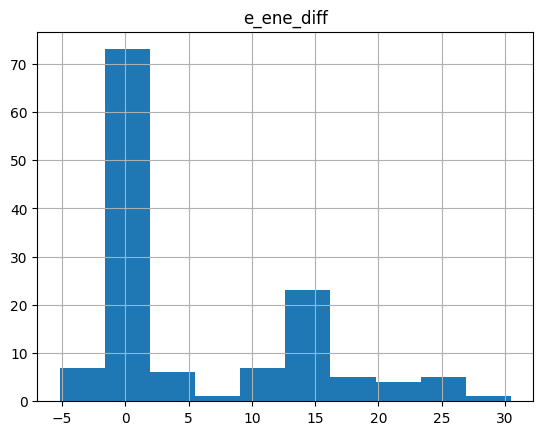

In [377]:
Serror_soapdf.hist('e_ene_diff')

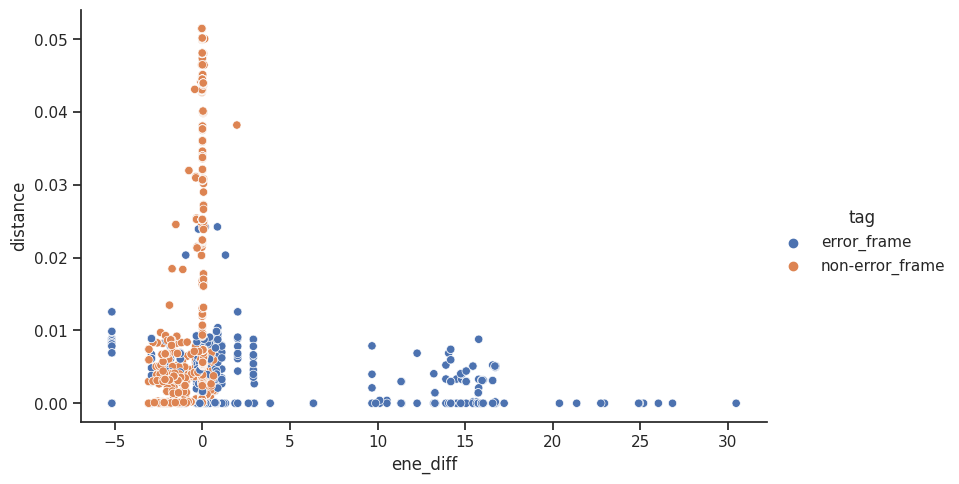

In [382]:
sns.relplot(data=Smatches20, x='ene_diff', y='distance', hue='tag',aspect=1.61)
plt.show()

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

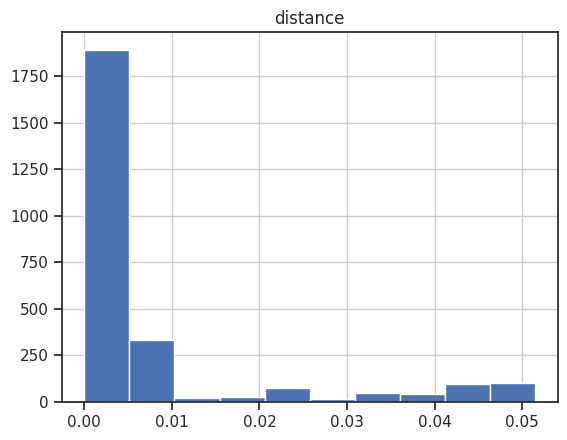

In [392]:
Smatches20.hist('distance')

In [458]:
non_similar_idx=set(Smatches20[Smatches20['distance']>0.01]['query-index'])

In [460]:
set(Smatches20[Smatches20['distance']>0.01]['query-index'])

{'10330',
 '105',
 '12891',
 '14770',
 '14822',
 '15019',
 '15409',
 '15540',
 '17016',
 '17340',
 '1767',
 '17723',
 '17821',
 '219',
 '22835',
 '24445',
 '24619',
 '25972',
 '27608',
 '28396',
 '28522',
 '30162',
 '30735',
 '31310',
 '32258',
 '33452',
 '34519',
 '35056',
 '382',
 '4706',
 '5023',
 '8160',
 '8331',
 '9585',
 '9762'}

In [ ]:
vis.visualize(idx_list=list(very_high_force_df['match-index']), traj=traj, method='SOAP', local_environment=True)